### Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set current working directory to parent folder
os.chdir(os.path.abspath(".."))

### Files

In [2]:
# Archivos importantes y paths
df_annotations = pd.read_excel('data/annotations.xlsx')

# Omitimos todos los audios en development
df_annotations = df_annotations[df_annotations['Type'] != 'Development'].reset_index(drop = True)

### Gráficos dinámicos

In [3]:
def obtener_anotaciones(conversation, emocion):

    time = pd.DataFrame()

    df_file = df_annotations[(df_annotations['Emotion'] == emocion) & (df_annotations['Conversation_Part'] == conversation)]
    
    for annotation, annotator in zip(df_file['Annotation_File'], df_file['Annotator']):
        temp_df = pd.read_csv(f'data/MSPCORPUS/Annotations/{emocion}/{annotation}', skiprows=9, header=None, names=['Time', 'Annotation'])
        temp_df['Annotator'] = annotator
        time = pd.concat([time, temp_df], ignore_index = True)
    
    df_pivot = pd.DataFrame(time.pivot_table(columns = 'Annotator', index = 'Time', values = 'Annotation').to_records()).set_index('Time')
    df_pivot = df_pivot.fillna(method='ffill')
    df_pivot['Emotion'] = emocion
    df_pivot = df_pivot.reset_index()
    
    return df_pivot

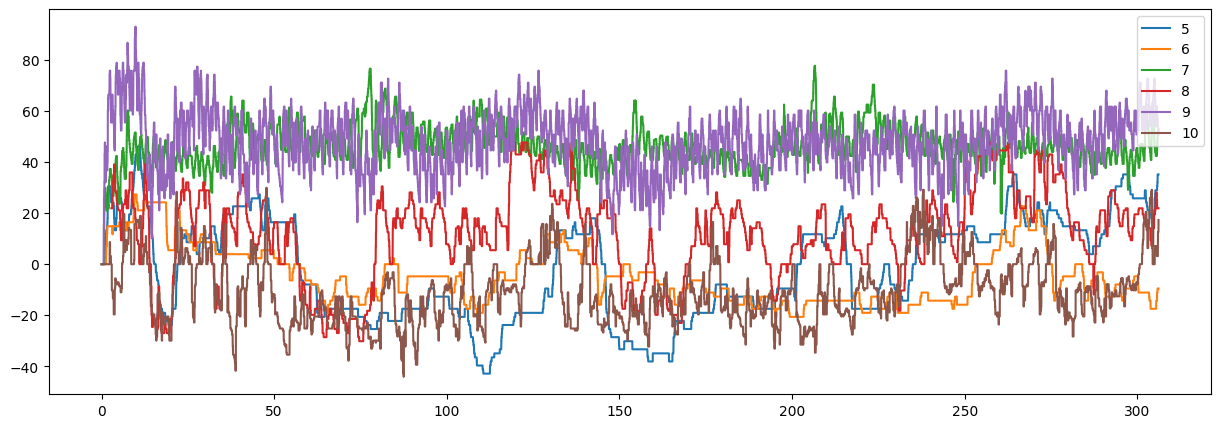

In [4]:
df_graf = obtener_anotaciones('MSP-Conversation_0021_1', 'Arousal')

graficos = df_graf.drop(['Time','Emotion'], axis = 1).columns

plt.figure(figsize = (15,5))
for grafico in graficos:
    if grafico == 'Vote_Roll':
        plt.plot(df_graf['Time'], df_graf[grafico], label = grafico, linewidth = 3)
    else:
        plt.plot(df_graf['Time'], df_graf[grafico], label = grafico)
    
plt.legend(loc = "upper right")
plt.xticks()
plt.show()

### Cálculo Cronbach’s Alpha 

In [5]:
import pingouin as pg

emociones = ['Valence','Dominance','Arousal']
X = []

for anotacion in df_annotations['Conversation_Part'].unique():
    
    for emocion in emociones:
        
        x = []
        
        df_graf = obtener_anotaciones(anotacion, emocion)
        df_graf = df_graf.drop(['Time','Emotion'], axis = 1)
        
        x.append(emocion)
        x.append(anotacion)
        x.append(pg.cronbach_alpha(data = df_graf)[0])
        
        X.append(x)

df_votacion = pd.DataFrame(X, columns = ['Emocion','Conversation_Part','Cronbanch'])

# Este archivo ya esta en el notebook, no se necesita recrear
# df_votacion.to_excel('data/cronbanch_parts.xlsx',index = False)

Ahora que ya tengo el cronbanch para cada uno de las conversation_part, puedo sacar los anotares segun conversation part

In [6]:
df_votacion.head()

,Emocion,Conversation_Part,Cronbanch
0,Valence,MSP-Conversation_0021_1,0.676759
1,Dominance,MSP-Conversation_0021_1,0.695732
2,Arousal,MSP-Conversation_0021_1,0.608602
3,Valence,MSP-Conversation_0021_2,0.521342
4,Dominance,MSP-Conversation_0021_2,0.463295


In [7]:
# Merge con annotations
df_final = pd.merge(df_votacion, df_annotations, how = 'left', left_on = ['Conversation_Part','Emocion'], right_on = ['Conversation_Part','Emotion']).drop('Emotion', axis = 1)

In [8]:
emociones = ['Valence','Arousal','Dominance']
annotators = df_final['Annotator'].unique()
X = []

for emocion in emociones:
    for annotator in annotators:
        
        convs = df_final[(df_final['Annotator'] == annotator) & (df_final['Emocion'] == emocion)]['Conversation_Part'].unique()
        
        # Sin
        df_restantes = df_final[(~df_final['Conversation_Part'].isin(convs)) & (df_final['Emocion'] == emocion)]
        val_sin = df_restantes[['Conversation_Part','Cronbanch']].drop_duplicates()['Cronbanch'].mean()
        
        # Con
        df_restantes = df_final[(df_final['Conversation_Part'].isin(convs)) & (df_final['Emocion'] == emocion)]
        val_con = df_restantes[['Conversation_Part','Cronbanch']].drop_duplicates()['Cronbanch'].mean()
        
        x = []
        x.append(annotator)
        x.append(emocion)
        x.append(val_sin)
        x.append(val_con)
        
        X.append(x)
        
df_cron = pd.DataFrame(X, columns = ['Anotador','Emocion','Sin','Con'])
df_cron['Diferencia'] = df_cron['Con'] - df_cron['Sin']

In [9]:
df_promedio = df_votacion.groupby('Emocion')[['Cronbanch']].mean()

In [10]:
x = []

for index, row in df_cron.iterrows():
    x.append(row['Con'] - df_promedio.loc[row['Emocion']]['Cronbanch'])
    
df_cron['Dif_Promedio'] = x

### Visualización Cronbanch Alpha

#### Cronbanch promedio para cada audio

In [11]:
df_promedio

,Cronbanch
Emocion,
Arousal,0.383447
Dominance,0.361631
Valence,0.510279


#### Sin / Con

In [12]:
df_cron.pivot(index = 'Anotador', columns = 'Emocion', values = ['Sin','Con'])

Sin                           Con                    
Emocion    Arousal Dominance   Valence   Arousal Dominance   Valence
Anotador                                                            
2         0.363421  0.346473  0.502234  0.506016  0.467526  0.568276
4         0.381188  0.360714  0.509470  0.648188  0.631403  0.748803
5         0.346465  0.324667  0.481454  0.502583  0.480706  0.603138
6         0.346465  0.324667  0.481454  0.502583  0.480706  0.603138
7         0.364790  0.359333  0.460966  0.387065  0.362234  0.520082
8         0.360399  0.339764  0.493290  0.522556  0.493613  0.618800
9         0.340970  0.324595  0.475772  0.446007  0.414668  0.558338
10        0.349973  0.333358  0.491092  0.409741  0.385249  0.527092
11        0.366649  0.342636  0.500179  0.504535  0.532901  0.599671
12        0.383447  0.360147  0.510279       NaN  0.535535       NaN
13        0.418649  0.473823  0.546103  0.376191  0.343556  0.503760
14        0.374810  0.355313  0.504440  0.415646  0.391211  0.536997
15        0.401851  0.374351  0.518655  0.301141  0.304091  0.472823
16        0.385014  0.366775  0.509957  0.346429  0.176750  0.518238
17        0.505167  0.482936  0.602710  0.346015  0.327423  0.485486
18        0.416989  0.379832  0.527795  0.220718  0.293775  0.440068
19        0.478488  0.459285  0.583485  0.299033  0.296711  0.452777
20        0.408393  0.378352  0.523479  0.318496  0.304049  0.467760
21        0.398439  0.366057  0.515739  0.242996  0.300651  0.454865
22        0.382772  0.367637  0.509811  0.395645  0.245223  0.525189
23        0.386194  0.367392  0.518676  0.361213  0.304332  0.433119
24        0.383792  0.362881  0.513861  0.378128  0.329290  0.417640
25        0.385102  0.364056  0.520784  0.348872  0.338905  0.399059
26        0.386380  0.362064  0.512478  0.228815  0.355811  0.469171
27        0.383447  0.361532  0.510240       NaN  0.368013  0.513592
28        0.383447  0.359735  0.510279       NaN  0.583838       NaN

#### Rank diferencias

In [13]:
df_cron.sort_values('Diferencia').head(50)

,Anotador,Emocion,Sin,Con,Diferencia,Dif_Promedio
42,18,Arousal,0.416989,0.220718,-0.196271,-0.162729
71,16,Dominance,0.366775,0.176750,-0.190025,-0.184881
39,19,Arousal,0.478488,0.299033,-0.179455,-0.084414
65,19,Dominance,0.459285,0.296711,-0.162574,-0.064919
35,17,Arousal,0.505167,0.346015,-0.159152,-0.037432
43,26,Arousal,0.386380,0.228815,-0.157565,-0.154632
61,17,Dominance,0.482936,0.327423,-0.155513,-0.034208
46,21,Arousal,0.398439,0.242996,-0.155443,-0.140451
13,19,Valence,0.583485,0.452777,-0.130709,-0.057503
60,13,Dominance,0.473823,0.343556,-0.130267,-0.018074


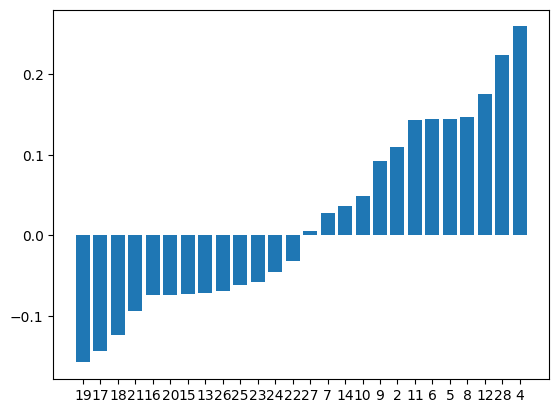

In [14]:
df_difs = df_cron.groupby('Anotador')[['Diferencia']].mean().reset_index().sort_values('Diferencia')

height = df_difs['Diferencia']
bars = df_difs['Anotador']
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

#### Ideas de balancear votación

1) Usar Diferencia / Dif_Promedio como modo de balanceo

2) Usar Diferencia / Dif_Promedio ajustados como modo de balanceo

#### Guardar archivo en formato json

In [15]:
pesos_votacion = {}

for emocion in emociones:
    
    df_temp = df_cron[df_cron['Emocion'] == emocion].fillna(0)
    
    pesos_votacion[emocion] = {}
    
    for ind, row in df_temp.iterrows():
        pesos_votacion[emocion][row['Anotador']] = {}
        pesos_votacion[emocion][row['Anotador']]['Diferencia'] = row['Diferencia']
        pesos_votacion[emocion][row['Anotador']]['Dif_Promedio'] = row['Dif_Promedio']

In [16]:
# Guardo el diccionario en archivo json
with open('data/pesos_anotadores.json', 'w') as f:
    json.dump(pesos_votacion, f)

### Sandbox

In [3]:
# Obtenemos el json con los pesos
with open('data/pesos_anotadores.json', 'r') as f:
    pesos_anotadores = json.load(f)

In [5]:
from src.votaciones import votacion_promedio_ponderada, votacion_promedio_simple

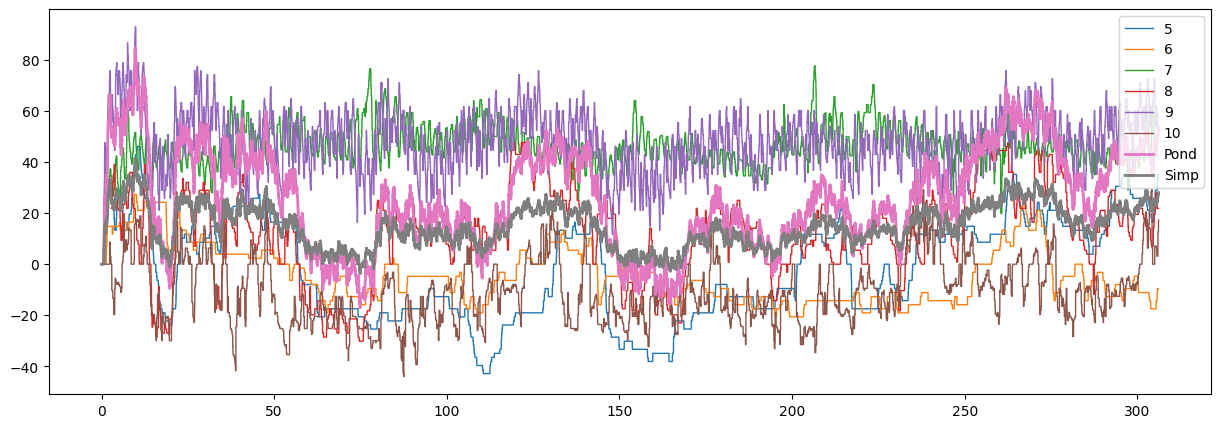

In [21]:
emocion = 'Arousal'
multiplicador = 10
part_num = 1
pc_num = '0021'

df_graf = obtener_anotaciones(f'MSP-Conversation_{pc_num}_{part_num}', emocion)

df_simp = votacion_promedio_simple(df_annotations, part_num = part_num, pc_num = int(pc_num))
df_pond = votacion_promedio_ponderada(df_annotations, pesos_anotadores, part_num = part_num, pc_num = int(pc_num), multiplicador = multiplicador)

graficos = df_graf.drop(['Time','Emotion'], axis = 1).columns

plt.figure(figsize = (15,5))
for grafico in graficos:
    plt.plot(df_graf['Time'], df_graf[grafico], label = grafico, linewidth = 1)

plt.plot(df_pond['Time'], df_pond[emocion], label = 'Pond', linewidth = 2)
plt.plot(df_simp['Time'], df_simp[emocion], label = 'Simp', linewidth = 2)

plt.legend(loc = "upper right")
plt.xticks()
plt.show()

#### Usado para guardar los otros dos json de diferencias de pesos

In [15]:
x = {}
y = {}
for emocion in pesos_anotadores.keys():
    x[emocion] = {}
    y[emocion] = {}
    for anotador in pesos_anotadores[emocion]:
        x[emocion][anotador] = pesos_anotadores[emocion][anotador]['Diferencia']
        y[emocion][anotador] = pesos_anotadores[emocion][anotador]['Dif_Promedio']

In [17]:
# Guardo el diccionario en archivo json
with open('data/pesos_anotadores_dif.json', 'w') as f:
    json.dump(x, f)

In [18]:
# Guardo el diccionario en archivo json
with open('data/pesos_anotadores_dif_prom.json', 'w') as f:
    json.dump(y, f)